# 0. Setup

In [ ]:
!nvidia-smi -L

In [2]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from misc.helpers import find_pth_files, calculate_true_distributions, calculate_sigma_from_distributions
from scipy.stats import entropy
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from model.vit_for_small_dataset import ViT
from utils.imageset_handler import ImageQualityDataset
from model.recorder import Recorder


In [3]:

def get_csv_files_in_directory(directory_path):
    csv_files = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".csv"):
                csv_files.append(os.path.join(root, file))
    return csv_files

def trans(img, img_size):
    # Define the normalization parameters (mean and std)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Define the transformation including normalization
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    img = transform(img)
    return img


def visualize_predict_single_layer(model, img, img_size, patch_size,layer_idx, device):
    img_pre = trans(img, img_size)
    attention = visualize_attention(model, img_pre, patch_size, device)
    plot_attention(img, attention,layer_idx)

def visualize_predict_all_layers(model, img, img_size, patch_size, device):
    img_pre = trans(img, img_size)
    attention = visualize_attention(model, img_pre, patch_size, device)
    plot_attention_per_layer(img, attention)


def visualize_attention(model, img, patch_size, device):
    model = Recorder(model) # Set Recorder
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size
    
    _, attentions = model(img)
    # print(attentions.shape) # torch.Size([1, 6, 16, 257, 257])
    nh = attentions.shape[2]  # number of head
    nl = attentions.shape[1]  # number of layers
    # print(f"Number of Layers: {nl}")
    # print(f"Number of Heads: {nh}")

    result_tensor = torch.zeros(6, 16, 256, 256)  # Initialize the result tensor

    for i in range(nl):
        # print(f"Before:{att.shape}")
        att = attentions[0,i,:,0,1:].reshape(nh, -1)
        # print(f"Reshape1:{att.shape}")

        att = att.reshape(nh, w_featmap, h_featmap)
        # print(f"Reshape2:{att.shape}")

        att = nn.functional.interpolate(att.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0]
        # print(f"Interpolation:{att.shape}")
        result_tensor[i, :, :, :] = att


    return result_tensor.cpu().numpy()

def plot_attention_per_layer(img, attention):
    n_heads = attention.shape[1]
    n_layers = attention.shape[0]
    image_size = (256, 256)  # Du kannst die gewünschte Bildgröße anpassen

    img_pre = transforms.Resize(image_size)(img)
    img_pre = transforms.CenterCrop(image_size)(img_pre)

    fig, axes = plt.subplots(n_heads + 1, n_layers + 1, figsize=(20, 50))

    for ax in axes.flat:
        ax.axis('off')

    # Originalbild
    axes[0, 0].imshow(img_pre)
    axes[0, 0].set_title("Original Image")

    for head_idx in range(n_heads+1):
        for layer_idx in range(n_layers):
            ax = axes[head_idx, layer_idx + 1]
            if head_idx == 0:
                layer_mean = np.mean(attention[layer_idx], axis=0)
                ax.imshow(img_pre, cmap='gray')
                ax.imshow(layer_mean, cmap='inferno', alpha=0.7)
                ax.set_title(f"Layer {layer_idx + 1}: Head Mean")
            else:           
                head = attention[layer_idx][head_idx-1]
                ax.imshow(img_pre, cmap='gray')
                ax.imshow(head, cmap='inferno', alpha=0.7)
                ax.set_title(f"Layer {layer_idx + 1}: Head {head_idx}")

    plt.show()

def plot_attention(img, attention, layer_idx):
    print(f"Attention Shape: {attention.shape}")
    n_heads = attention.shape[1]
    print(f"Heads: {n_heads}")
    img_pre = transforms.Resize(attention.shape[-1])(img)
    img_pre = transforms.CenterCrop(attention.shape[-1])(img_pre)
    attention = attention[layer_idx]
    # Display the PIL Image using matplotlib (optional)
    plt.imshow(img)
    plt.figure(figsize=(10, 10))
    text = ["Original Image"]+[f"Layer {layer_idx}: Head Mean"]
    att_mean = np.mean(attention,0)
    lst = [img_pre] + [att_mean]

    # print(len(lst))
    for i, fig in enumerate(lst):
        plt.subplot(1,len(lst),i+1)
        if i != 0:
            plt.imshow(img_pre)
            plt.imshow(fig, cmap='inferno',alpha=0.7)
        else:
            plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
        
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//4, 4, i+1)
        plt.imshow(img_pre)
        plt.imshow(attention[i], cmap='inferno', alpha=0.7)
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()

# 1. Build Model

### 1.1 Define Variables

In [4]:
image_size=256
patch_size=16
num_classes=5  # Number of classes for image quality levels
dim=1024
depth=6
heads=16
mlp_dim=2048
emb_dropout=0.1

### 1.2 Compile

In [5]:
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    emb_dropout=emb_dropout
)
print(model)

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (

# 2 Load Dataset

In [6]:
weights_dir = 'results/weights/Cross-Entropy_3_Iter_no_var/AIO1/AIO1_3_test'

csv_file = 'assets/Test/Obs0.csv'
dataset_root =  'assets/Test/DSX'
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2.1 Add Augmentation (Transformation)

In [7]:
# Define the normalization parameters (mean and std)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the transformation including normalization
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

### 2.2 Loading

In [8]:
# Initialize your dataset loader and test dataset
test_dataset = ImageQualityDataset(csv_file,dataset_root, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model.to(device)

Number of images in class 0: 60
Number of images in class 1: 60
Number of images in class 2: 60
Number of images in class 3: 60
Number of images in class 4: 60

Number of images in the dataset: 300


# 3. Evaluate

### Evaluating training run

In [ ]:
# Varianz
sigma = 0.4

# List of different weight files
weight_files = find_pth_files(weights_dir)

results = []
example_pred_results = []

for weight_file in weight_files:
    print(f'Weights-file: {os.path.basename(weight_file)} will be evaluated')
    # Load the model with different weights
    model.load_state_dict(torch.load(weight_file))
    model.eval()

    # init result lists
    true_labels = []
    test_preds = []
    entropies = []
    true_entropies =[]
    weighted_sums = []
    kl_divs = []
    with torch.no_grad():

        for i, (images, image_paths, labels) in enumerate(test_loader, 0):
            # images = images.to(device)
            # labels = labels.to(device)
            print(f"Example Prediction of Batch: {i}")
            outputs, _ = model(images)
            true_labels.extend(labels)

            # Convert logits to probabilities
            probabilities = nn.functional.softmax(outputs, dim=1)
            
            # Calculate the true distribution based on 'sigma'
            true_distributions = calculate_true_distributions(labels,sigma,num_classes,device='cpu')

            # Get predicition by the maximum probability
            _, preds = torch.max(outputs, dim=1)
            test_preds.extend(preds.cpu().numpy())
            
            formatted_probabilities = ["{:.4f}".format(prob) for prob in probabilities[0]]
            # print(f"Predicted Probabilities:{formatted_probabilities}")
            # print(f'Predicted Label: {preds[0]}')


            # Calculate Entropy
            entropy_values = entropy(probabilities.numpy(),base=np.exp(1), axis=1)
            true_entropy_values = entropy(true_distributions.numpy(),base=np.exp(1), axis=1)
            # Format entropies in a readble way
            entropies.extend(entropy_values)
            true_entropies.extend(entropy_values)
            # print(f'Mean Entropie of batch: {np.mean(entropy_values)}')

            # Calculate KL Divergence
            # kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='none')
            # print(f'KL-Divergence none: {kl_div[0]}')
            # kl_div = torch.sum(kl_div, dim=1).numpy()
            # print(f'KL-Divergence sum: {kl_div[0]}')
            # kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='mean')
            # print(f'KL-Divergence mean: {kl_div}')

            kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='batchmean')
            # print(f'KL-Divergence batchmean: {kl_div}')
            kl_divs.append(kl_div.item())
            
            # Define weighting factors
            weighting_factors = [0,1,2,3,4]
            # Calculate the weighted sum of probabilities
            weighted_sum = torch.sum(probabilities * torch.tensor(weighting_factors), dim=1).cpu().numpy()
            # Format weighted sum in a readble way
            weighted_sums.extend(weighted_sum)
            # Example printout for the first batch
            if i == 0 or i == 1:
                example_pred_result = {
                    "Weights File": os.path.basename(weight_file),
                    "Image Name": os.path.basename(image_paths[i]),
                    "True Label": labels.cpu().numpy()[i],
                    "Predicted Label": preds.cpu().numpy()[i],
                    "Weighted Sum of Probability": weighted_sum[i],
                    "True Probability Distribution": true_distributions[i].cpu().numpy().tolist(),
                    "Predicted Probability Distribution": probabilities[i].cpu().numpy().tolist(),
                    "Entropy Value": entropy_values[i],
                    "True Entropy Value": true_entropy_values[i],
                    "KL Divergence (batch-mean)": kl_divs[i],
                }
                example_pred_results.append(example_pred_result)
            print(f'True-Label: {labels.cpu()[0]}')
            print(f'Predicted-Label: {preds.cpu().numpy()[0]}')
            print(f'Weighted Sum of Probability: {round(weighted_sum[0],4)}')  # Gewichtete Summe der Wahrscheinlichkeiten
            print(f'Predicted Probality Distribution: {[round(prob,4) for prob in probabilities[0].numpy()]}')
            print(f'True Probality Distribution: {true_distributions.cpu().numpy()[0]}')
            print(f'Entropy Value: {round(entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
            print(f'True Entropy Value: {round(true_entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
            print(f'KL Divergence (batch-mean): {round(kl_div.item(),4)}\n')



    # Calculate the MSE of weighted sum and ground truth
    mse_weighted = mean_squared_error(true_labels, weighted_sums)

    # Calculate the MSE of most likely class and ground truth
    mse = mean_squared_error(true_labels, test_preds)
    
    # Calculate the Mean Entropy
    mean_entropy = np.mean(entropies)
    
    # Calculate the Mean KL Divergence
    mean_kl_div = np.mean(kl_divs)

    # Calculate Accuracy
    accuracy = accuracy_score(true_labels, test_preds)

    # Generate classification report
    class_report = classification_report(true_labels, test_preds)

    # Generate confusion matrix
    confusion = confusion_matrix(true_labels, test_preds)
    print('#'*50)
    print('model summary:')
    # print(f'Weight: {os.path.basename(weight_file)}, Accuracy: {accuracy}, Mean Entropy: {mean_entropy}, Mean KL Div: {mean_kl_div:.4f}, weighted mean mse: {mse_weighted},\nClassification Report:\n{class_report}')
    # Save confusion matrix as a figure
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig(weight_file.replace(".pth", "_confusion.png"))
    plt.close()
    result = {
        "Weights File": os.path.basename(weight_file),
        "Accuracy": accuracy,
        "MSE": mse,
        "MSE weighted": mse_weighted,
        "Mean Entropy": mean_entropy,
        "Mean KL Divergence": mean_kl_div, 
        "Classification Report": class_report
    }
    # Store the results
    results.append(result)
    # Print summary
    for key, value in result.items():
        print(f"{key}: {value}")
    print('#'*50)

# Create a DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_path = os.path.join(weights_dir, "model_comparison_results.csv")
results_df.to_csv(results_path, index=False)

# Save example printouts to a CSV file for this model
example_printouts_df = pd.DataFrame(example_pred_results)
example_printout_file = os.path.join(weights_dir, "model_comparison_results_examples.csv")
example_printouts_df.to_csv(example_printout_file, index=False)

### Eval std for predicted images

In [1]:
import os
import random
import torch
import numpy as np
import pandas as pd
from torchvision import transforms
from PIL import Image
from collections import Counter
# from scipy.stats import gaussian_kde, norm
import scipy.stats as stats

# Load your trained model
model_path = "results/weights/Cross-Entropy_3_Iter_no_var/AIO1/AIO1_1/vit_model_20231106_163904_epoch_24of50_valLoss_1.781_valAcc_0.543_batchsize_128_lr_0.0_DS1.pth"
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    emb_dropout=emb_dropout
)  # Replace with actual model loading code
model.load_state_dict(torch.load(model_path))
model.eval()
# Load the CSV file containing image names
csv_path = "assets/DS_iterative/Obs1/Obs1_2.csv"
csv_data = pd.read_csv(csv_path)

# Generate predictions and filter based on variance
image_folder = "assets/Dataset/DS0"
prediction_list = []
data =[]
count = 0
for i in range(100):
    # image_name = f"{i}.jpg"#
    image_name = random.choice(os.listdir(image_folder))
    print(image_name)
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path)
    # Check if the image is grayscale (1 channel), and convert to RGB if needed
    if image.mode == 'L':
        image = image.convert('RGB')
    image = transform(image)
    
    with torch.no_grad():
        output, _ = model(image.unsqueeze(0))  # Assuming your model takes batch size 1
        # Convert logits to probabilities
        probabilities = nn.functional.softmax(output, dim=1).numpy()
        print(probabilities)
     # Calculate the kernel density estimate (KDE) for the data distribution
    x = np.array([], dtype=int)
    for prob in probabilities:
        x = np.concatenate([x, np.ones(int(prob[0] * 1000)),
                            2 * np.ones(int(prob[1] * 1000)),
                            3 * np.ones(int(prob[2] * 1000)),
                            4 * np.ones(int(prob[3] * 1000)),
                            5 * np.ones(int(prob[4] * 1000))])
    kde = stats.gaussian_kde(x)
    # Compute the median and mean using KDE
    med = np.median(x)
    print(med)
    nor = stats.norm(x.mean(),x.std())
    # print(nor)
    print(nor.std())
    mean = kde.resample(1).mean()
    print(mean)

    variance = np.var(probabilities)
    print(variance)
    sigma = np.std(probabilities)
    print(sigma)
    print("\n")
    std_normal = nor.std
    if nor.std() > 0.7:
        prediction_list.append(image_name)
        data.append((image_name, nor.std()))
        count += 1
    if len(prediction_list) >= 300:
        break

# Find missing entries
csv_image_names = csv_data['Image Name'].tolist()
duplicate_status = "DUPLICATE" if Counter(prediction_list) == Counter(csv_image_names) else "NOT DUPLICATE"

if duplicate_status == "NOT DUPLICATE":
    missing_entries = list(set(prediction_list) - set(csv_image_names))

    # Create a CSV file with missing entries
    # missing_entries_df = pd.DataFrame({'ImageName': missing_entries})
    missing_entries_df = pd.DataFrame(data, columns=['ImageName', 'Std'])
    missing_csv_path = "missing_entries.csv"
    missing_entries_df.to_csv(missing_csv_path, index=False)
else:
    missing_csv_path = None

print(duplicate_status)
print(f"Number of std to high: {count}")
if missing_csv_path:
    print(f"Missing entries saved to {missing_csv_path}")


KeyboardInterrupt: 

In [9]:
# Load your trained model
weight_file = 'results/AIOs/AIO0.pth'
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    emb_dropout=emb_dropout
)  # Replace with actual model loading code
model.load_state_dict(torch.load(weight_file))
model.eval()

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (

In [16]:
import os
import random
import torch
import numpy as np
import pandas as pd
from torchvision import transforms
from PIL import Image
from collections import Counter
# from scipy.stats import gaussian_kde, norm
import scipy.stats as stats

prediction_list = []
data =[]
count = 0
kdes = []
with torch.no_grad():

    for i, (images, image_paths, labels) in enumerate(test_loader, 0):
        # images = images.to(device)
        # labels = labels.to(device)
        print(f"Example Prediction of Batch: {i}")
        outputs = model(images)

        # Convert logits to probabilities
        probabilities = nn.functional.softmax(outputs, dim=1)

        # print(probabilities)
        print(probabilities.shape) # 128,5
        # for prob in probabilities:
        #     kde = stats.gaussian_kde(prob.numpy())
        #     kdes.append(kde)
        sigma_values = calculate_sigma_from_distributions(probabilities,num_classes=num_classes,device='cpu')
        # Print values above 0.7
        above_threshold_indices = sigma_values > 0.7
        above_threshold_values = sigma_values[above_threshold_indices]

        print("Indices where sigma values are above 0.7:", above_threshold_indices)
        print("Sigma values above 0.7:", above_threshold_values)
        med = torch.median(probabilities,dim=1)
        print(f"Median: {med.values}")

        median_kde = stats.gaussian_kde(med.values.numpy())
        print(f"Median (KDE): {median_kde}")
        
        mean = torch.mean(probabilities, dim=1)
        print(f"Mean: {mean}")
        std = torch.std(probabilities, dim=1)
        print(f"Standardabweichung {std}")
        std_kde = stats.gaussian_kde(std.numpy())
        print(f"Standardabweichung {std_kde}")

        # Create a normal distribution based on the median and std KDE
        normal = stats.norm(loc=median_kde.dataset.mean(), scale=std_kde.dataset.std())
        print(f"Normaldistribution: {normal}")
        std_normal = normal.std()
        print(std_normal)
        # Erstellen einer Normalverteilung in PyTorch
        normal = torch.distributions.normal.Normal(median_kde.dataset.mean(), std_kde.dataset.std())
        print(f"Normaldistribution: {normal}")
        std_normal = normal.stddev
        print(std_normal)
        # Assuming std_normal is a PyTorch tensor
        indices_above_threshold = (std_normal > 0.7).nonzero()  # Find indices where std_normal > 0.7
        values_above_threshold = std_normal[std_normal > 0.7]  # Get values where std_normal > 0.7

        print("Indices where std_normal > 0.7:", indices_above_threshold.numpy())
        print("Values where std_normal > 0.7:", values_above_threshold.numpy())

Example Prediction of Batch: 0
torch.Size([128, 5])
Indices where sigma values are above 0.7: tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False

### eval iter

In [ ]:
def list_subdirectories(root_dir):
    subdirectories = []
    for subdir in os.listdir(root_dir):
        subdirectories.append(os.path.join(root_dir, subdir))
    return subdirectories

In [ ]:
csv_file = 'assets/Test/Obs5.csv'
dataset_root =  'assets/Test/DSX'

# Initialize your dataset loader and test dataset
test_dataset = ImageQualityDataset(csv_file,dataset_root, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
directory_paths = ['results/weights/Cross-Entropy_3_Iter_var_0.4/AIO5','results/weights/Cross-Entropy_3_Iter_no_var/AIO5', 'results/weights/KL-Div_3_Iter_var_0.4/AIO5']
# directory_path = 'results/weights/KL-Div_3_Iter_var_0.4/AIO2'
for directory_path in directory_paths:
    subdirs = list_subdirectories(directory_path)
    # Varianz
    sigma = 0.4

    for weights_dir in subdirs:
        # List of different weight files
        weight_files = find_pth_files(weights_dir)

        results = []
        example_pred_results = []

        for weight_file in weight_files:
            print(f'Weights-file: {os.path.basename(weight_file)} will be evaluated')
            # Load the model with different weights
            model.load_state_dict(torch.load(weight_file))
            model.eval()

            # init result lists
            true_labels = []
            test_preds = []
            entropies = []
            true_entropies =[]
            weighted_sums = []
            kl_divs = []
            with torch.no_grad():

                for i, (images, image_paths, labels) in enumerate(test_loader, 0):
                    # images = images.to(device)
                    # labels = labels.to(device)
                    print(f"Example Prediction of Batch: {i}")
                    outputs, _ = model(images)
                    true_labels.extend(labels)

                    # Convert logits to probabilities
                    probabilities = nn.functional.softmax(outputs, dim=1)
                    
                    # Calculate the true distribution based on 'sigma'
                    true_distributions = calculate_true_distributions(labels,sigma,num_classes,device='cpu')

                    # Get predicition by the maximum probability
                    _, preds = torch.max(outputs, dim=1)
                    test_preds.extend(preds.cpu().numpy())
                    
                    formatted_probabilities = ["{:.4f}".format(prob) for prob in probabilities[0]]
                    # print(f"Predicted Probabilities:{formatted_probabilities}")
                    # print(f'Predicted Label: {preds[0]}')


                    # Calculate Entropy
                    entropy_values = entropy(probabilities.numpy(),base=np.exp(1), axis=1)
                    true_entropy_values = entropy(true_distributions.numpy(),base=np.exp(1), axis=1)
                    # Format entropies in a readble way
                    entropies.extend(entropy_values)
                    true_entropies.extend(entropy_values)
                    # print(f'Mean Entropie of batch: {np.mean(entropy_values)}')

                    # Calculate KL Divergence
                    # kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='none')
                    # print(f'KL-Divergence none: {kl_div[0]}')
                    # kl_div = torch.sum(kl_div, dim=1).numpy()
                    # print(f'KL-Divergence sum: {kl_div[0]}')
                    # kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='mean')
                    # print(f'KL-Divergence mean: {kl_div}')

                    kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='batchmean')
                    # print(f'KL-Divergence batchmean: {kl_div}')
                    kl_divs.append(kl_div.item())
                    
                    # Define weighting factors
                    weighting_factors = [0,1,2,3,4]
                    # Calculate the weighted sum of probabilities
                    weighted_sum = torch.sum(probabilities * torch.tensor(weighting_factors), dim=1).cpu().numpy()
                    # Format weighted sum in a readble way
                    weighted_sums.extend(weighted_sum)
                    # Example printout for the first batch
                    if i == 0 or i == 1:
                        example_pred_result = {
                            "Weights File": os.path.basename(weight_file),
                            "Image Name": os.path.basename(image_paths[i]),
                            "True Label": labels.cpu().numpy()[i],
                            "Predicted Label": preds.cpu().numpy()[i],
                            "Weighted Sum of Probability": weighted_sum[i],
                            "True Probability Distribution": true_distributions[i].cpu().numpy().tolist(),
                            "Predicted Probability Distribution": probabilities[i].cpu().numpy().tolist(),
                            "Entropy Value": entropy_values[i],
                            "True Entropy Value": true_entropy_values[i],
                            "KL Divergence (batch-mean)": kl_divs[i],
                        }
                        example_pred_results.append(example_pred_result)
                    print(f'True-Label: {labels.cpu()[0]}')
                    print(f'Predicted-Label: {preds.cpu().numpy()[0]}')
                    print(f'Weighted Sum of Probability: {round(weighted_sum[0],4)}')  # Gewichtete Summe der Wahrscheinlichkeiten
                    print(f'Predicted Probality Distribution: {[round(prob,4) for prob in probabilities[0].numpy()]}')
                    print(f'True Probality Distribution: {true_distributions.cpu().numpy()[0]}')
                    print(f'Entropy Value: {round(entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
                    print(f'True Entropy Value: {round(true_entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
                    print(f'KL Divergence (batch-mean): {round(kl_div.item(),4)}\n')



            # Calculate the MSE of weighted sum and ground truth
            mse_weighted = mean_squared_error(true_labels, weighted_sums)

            # Calculate the MSE of most likely class and ground truth
            mse = mean_squared_error(true_labels, test_preds)
            
            # Calculate the Mean Entropy
            mean_entropy = np.mean(entropies)
            
            # Calculate the Mean KL Divergence
            mean_kl_div = np.mean(kl_divs)

            # Calculate Accuracy
            accuracy = accuracy_score(true_labels, test_preds)

            # Generate classification report
            class_report = classification_report(true_labels, test_preds)

            # Generate confusion matrix
            confusion = confusion_matrix(true_labels, test_preds)
            print('#'*50)
            print('model summary:')
            # print(f'Weight: {os.path.basename(weight_file)}, Accuracy: {accuracy}, Mean Entropy: {mean_entropy}, Mean KL Div: {mean_kl_div:.4f}, weighted mean mse: {mse_weighted},\nClassification Report:\n{class_report}')
            # Save confusion matrix as a figure
            plt.figure(figsize=(8, 6))
            sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title("Confusion Matrix")
            plt.savefig(weight_file.replace(".pth", "_confusion.png"))
            plt.close()
            result = {
                "Weights File": os.path.basename(weight_file),
                "Accuracy": accuracy,
                "MSE": mse,
                "MSE weighted": mse_weighted,
                "Mean Entropy": mean_entropy,
                "Mean KL Divergence": mean_kl_div, 
                "Classification Report": class_report
            }
            # Store the results
            results.append(result)
            # Print summary
            for key, value in result.items():
                print(f"{key}: {value}")
            print('#'*50)

        # Create a DataFrame and save to CSV
        results_df = pd.DataFrame(results)
        results_path = os.path.join(weights_dir, "model_comparison_results.csv")
        results_df.to_csv(results_path, index=False)

        # Save example printouts to a CSV file for this model
        example_printouts_df = pd.DataFrame(example_pred_results)
        example_printout_file = os.path.join(weights_dir, "model_comparison_results_examples.csv")
        example_printouts_df.to_csv(example_printout_file, index=False)

### cross comparison

In [20]:
dataset_root = "assets/Test/DSX"
directory_path = "assets/Test"
csv_files_list = get_csv_files_in_directory(directory_path)
print(csv_files_list)


['assets/Test/Obs2.csv', 'assets/Test/Obs1.csv', 'assets/Test/Obs5.csv', 'assets/Test/Obs3.csv', 'assets/Test/Obs4.csv', 'assets/Test/Obs0.csv']


In [ ]:
directory_path = "assets/Test"
csv_files_list = get_csv_files_in_directory(directory_path)

weights_dir = "results/AIOs_iterativ+selfacc"
# List of different weight files
weight_files = find_pth_files(weights_dir)

# Varianz
sigma = 0.7
obs = [[] for _ in range(6)]

for csv_file in csv_files_list:
    # Initialize your dataset loader and test dataset
    test_dataset = ImageQualityDataset(csv_file,dataset_root, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    obs_idx = int(''.join(filter(str.isdigit, csv_file)))
    results = []
    example_pred_results = []
    aio_acc = [0] * len(weight_files)

    for weight_file in weight_files:
        print(f'Weights-file: {os.path.basename(weight_file)} will be evaluated')
        # Load the model with different weights
        model.load_state_dict(torch.load(weight_file))
        model.eval()
        aio_idx = int(''.join(filter(str.isdigit, os.path.basename(weight_file))))
        # init result lists
        true_labels = []
        test_preds = []
        entropies = []
        true_entropies =[]
        weighted_sums = []
        kl_divs = []
        with torch.no_grad():
            for i, (images,image_paths, labels) in enumerate(test_loader, 0):
                # images = images.to(device)
                # labels = labels.to(device)
                print(f"Example Prediction of Batch: {i}")
                outputs, _ = model(images)
                true_labels.extend(labels)

                # Convert logits to probabilities
                probabilities = nn.functional.softmax(outputs, dim=1)
                 
                if obs_idx != 0 and aio_idx !=0 or obs_idx != 0:
                    # Calculate the true distribution based on 'sigma'
                    true_distributions = calculate_true_distributions(labels,sigma,num_classes,device='cpu')
                else:
                    true_distributions = torch.nn.functional.one_hot(labels, num_classes).float()

                # Get predicition by the maximum probability
                _, preds = torch.max(outputs, dim=1)
                test_preds.extend(preds.cpu().numpy())
                
                formatted_probabilities = ["{:.4f}".format(prob) for prob in probabilities[0]]
                # print(f"Predicted Probabilities:{formatted_probabilities}")
                # print(f'Predicted Label: {preds[0]}')


                # Calculate Entropy
                entropy_values = entropy(probabilities.numpy(),base=np.exp(1), axis=1)
                true_entropy_values = entropy(true_distributions.numpy(),base=np.exp(1), axis=1)
                # Format entropies in a readble way
                entropies.extend(entropy_values)
                true_entropies.extend(entropy_values)
                # print(f'Mean Entropie of batch: {np.mean(entropy_values)}')

                # Calculate KL Divergence
                # kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='none')
                # print(f'KL-Divergence none: {kl_div[0]}')
                # kl_div = torch.sum(kl_div, dim=1).numpy()
                # print(f'KL-Divergence sum: {kl_div[0]}')
                # kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='mean')
                # print(f'KL-Divergence mean: {kl_div}')

                kl_div = torch.nn.functional.kl_div(torch.log(probabilities), true_distributions, reduction='batchmean')
                # print(f'KL-Divergence batchmean: {kl_div}')
                kl_divs.append(kl_div.item())
                
                # Define weighting factors
                weighting_factors = [0,1,2,3,4]
                # Calculate the weighted sum of probabilities
                weighted_sum = torch.sum(probabilities * torch.tensor(weighting_factors), dim=1).cpu().numpy()
                # Format weighted sum in a readble way
                weighted_sums.extend(weighted_sum)
                # Example printout for the first batch
                if i == 0 or i == 1:
                    example_pred_result = {
                        "Weights File": os.path.basename(weight_file),
                        "Image Name": os.path.basename(image_paths[i]),
                        "True Label": labels.cpu().numpy()[i],
                        "Predicted Label": preds.cpu().numpy()[i],
                        "Weighted Sum of Probability": weighted_sum[i],
                        "True Probability Distribution": true_distributions[i].cpu().numpy().tolist(),
                        "Predicted Probability Distribution": probabilities[i].cpu().numpy().tolist(),
                        "Entropy Value": entropy_values[i],
                        "True Entropy Value": true_entropy_values[i],
                        "KL Divergence (batch-mean)": kl_divs[i],
                    }
                    example_pred_results.append(example_pred_result)
                print(f'Image Name: {os.path.basename(image_paths[i])}')
                print(f'True-Label: {labels.cpu()[0]}')
                print(f'Predicted-Label: {preds.cpu().numpy()[0]}')
                print(f'Weighted Sum of Probability: {round(weighted_sum[0],4)}')  # Gewichtete Summe der Wahrscheinlichkeiten
                print(f'Predicted Probality Distribution: {[round(prob,4) for prob in probabilities[0].numpy()]}')
                print(f'True Probality Distribution: {true_distributions.cpu().numpy()[0]}')
                print(f'Entropy Value: {round(entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
                print(f'True Entropy Value: {round(true_entropy_values[0],4)}') # High Value: spreading; Low Value: concentrated
                print(f'KL Divergence (batch-mean): {round(kl_div.item(),4)}\n')



        # Calculate the MSE of weighted sum and ground truth
        mse_weighted = mean_squared_error(true_labels, weighted_sums)

        # Calculate the MSE of most likely class and ground truth
        mse = mean_squared_error(true_labels, test_preds)
        
        # Calculate the Mean Entropy
        mean_entropy = np.mean(entropies)
        
        # Calculate the Mean KL Divergence
        mean_kl_div = np.mean(kl_divs)

        # Calculate Accuracy
        accuracy = accuracy_score(true_labels, test_preds)

        # Generate classification report
        class_report = classification_report(true_labels, test_preds)

        # Generate confusion matrix
        confusion = confusion_matrix(true_labels, test_preds)
        print('\n')
        print('#'*50)
        print('model summary:')
        # print(f'Weight: {os.path.basename(weight_file)}, Accuracy: {accuracy}, Mean Entropy: {mean_entropy}, Mean KL Div: {mean_kl_div:.4f}, weighted mean mse: {mse_weighted},\nClassification Report:\n{class_report}')
        # Save confusion matrix as a figure
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.savefig(weight_file.replace(".pth", f"_{os.path.splitext(os.path.basename(csv_file))[0]}_confusion.png"))
        plt.close()
        result = {
            "Weights File": os.path.basename(weight_file),
            "Accuracy": accuracy,
            "MSE": mse,
            "MSE weighted": mse_weighted,
            "Mean Entropy": mean_entropy,
            "Mean KL Divergence": mean_kl_div, 
            "Classification Report": class_report
        }
        # Store the results
        results.append(result)
        aio_acc[aio_idx]=accuracy
        # Print summary
        for key, value in result.items():
            print(f"{key}: {value}")
        print('#'*50)
        print('\n')

    obs[obs_idx]=aio_acc
    # Create a DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_path = os.path.join(weights_dir, f"model_comparison_results_{os.path.splitext(os.path.basename(weights_dir))[0]}_{os.path.splitext(os.path.basename(csv_file))[0]}.csv")
    results_df.to_csv(results_path, index=False)

    # Save example printouts to a CSV file for this model
    example_printouts_df = pd.DataFrame(example_pred_results)
    example_printout_file = os.path.join(weights_dir, f"model_comparison_results_examples_{os.path.splitext(os.path.basename(weights_dir))[0]}_{os.path.splitext(os.path.basename(csv_file))[0]}.csv")
    example_printouts_df.to_csv(example_printout_file, index=False)


# Create a DataFrame for the obs list with proper headers and index
obs_df = pd.DataFrame(obs, columns=[f"AIO{i}" for i in range(6)], index=[f"Obs{i}" for i in range(6)])

# Specify the path to save the obs table as a CSV file
obs_path = os.path.join(weights_dir,"cross_comparison.csv")

# Save the DataFrame to a CSV file
obs_df.to_csv(obs_path)

# 4. Plot

### Plot Distributions

#### Predicted Distribution

#### Predicted Distribution

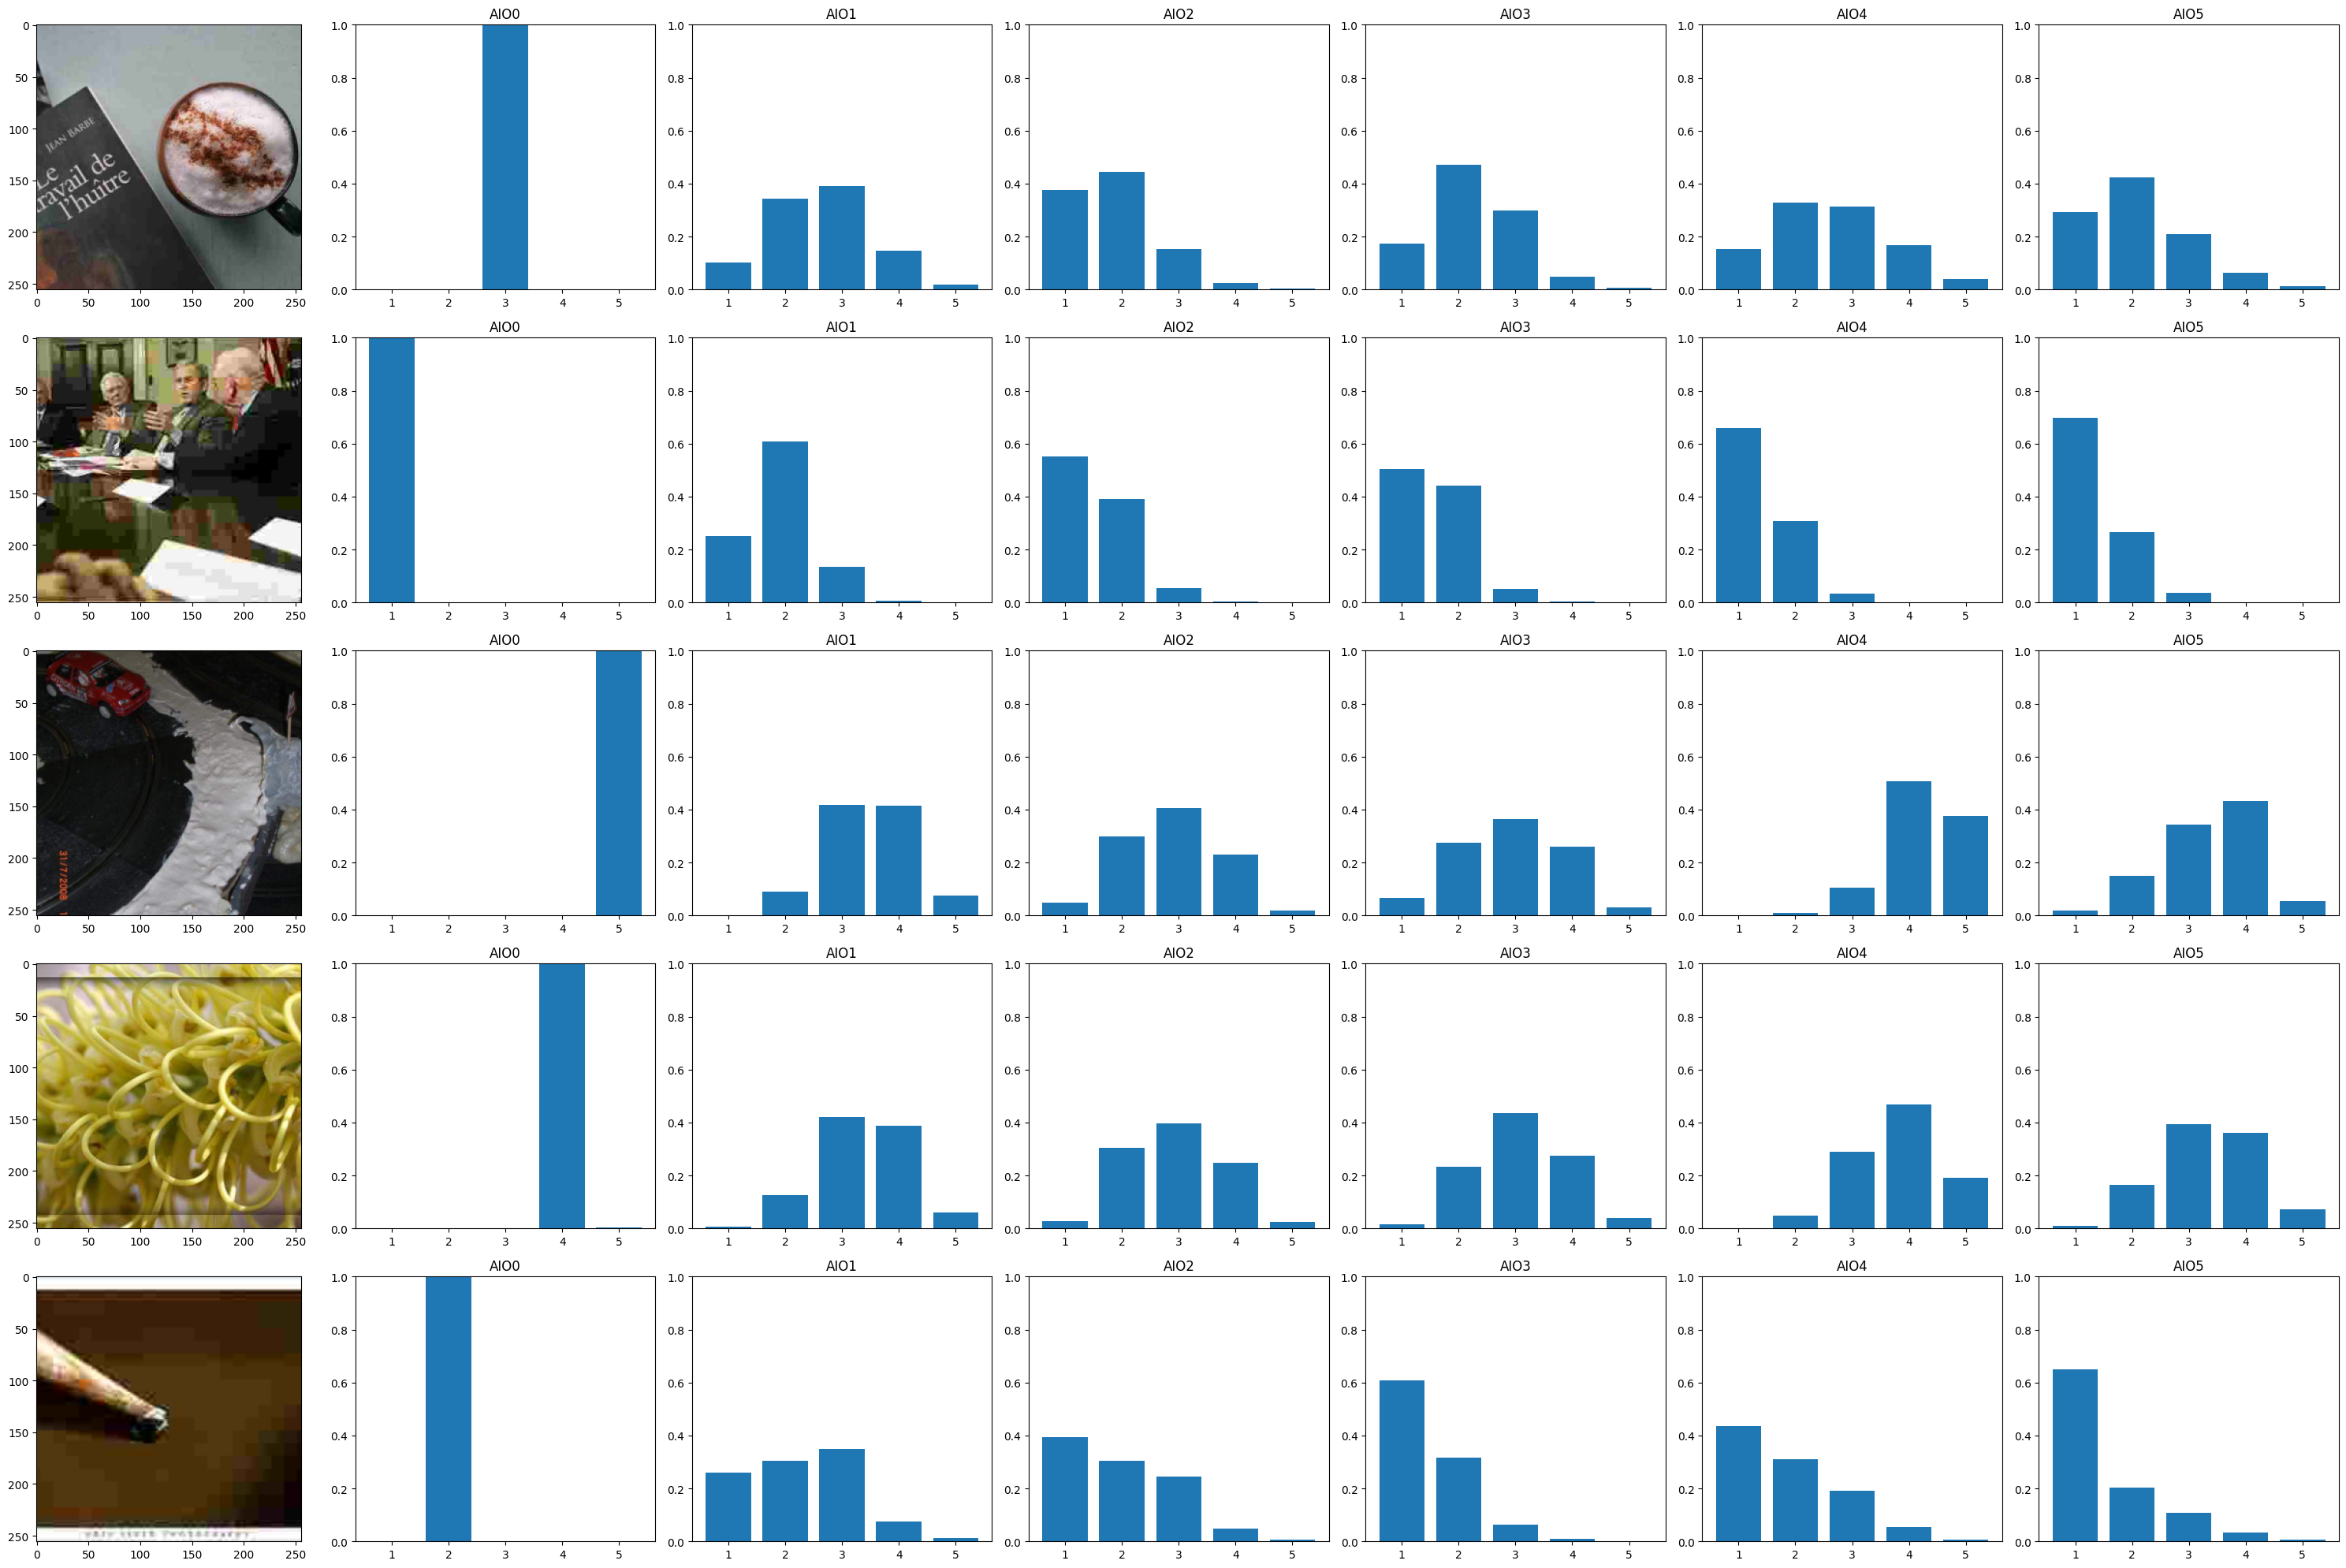

In [7]:
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import numpy as np

weights_dir = "results/AIOs"
# List of different weight files
weight_files = find_pth_files(weights_dir)
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(6)]
# Definiere den Ordner mit den Bildern
images_dir = "assets/work_imgs"

# Definiere eine Funktion zur Vorhersage und Visualisierung
def predict_and_visualize(model, image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = transform(image)
    image = image.unsqueeze(0)  # Füge eine Batch-Dimension hinzu

    with torch.no_grad():
        model.eval()
        output= model(image)

    probabilities = torch.softmax(output, dim=1).numpy()[0]
    return probabilities
weight_files = [0] + weight_files
# Initialisiere Matplotlib-Figuren
num_weights = len(weight_files)
num_images = len(os.listdir(images_dir))
fig, axes = plt.subplots(num_images, num_weights, figsize=(30, 20))

for i, weight_file in enumerate(weight_files):
    if i != 0:
        model.load_state_dict(torch.load(weight_file))

    for j, image_filename in enumerate(os.listdir(images_dir)):
        image_path = os.path.join(images_dir, image_filename)
        ax = axes[j,i]

        if i == 0:  # Only the first column should have images
            # Load the image and display it on the y-axis
            img = Image.open(image_path)
            img= transforms.Resize(image_size)(img)
            img = transforms.CenterCrop(image_size)(img) 
            ax.imshow(img)
        else:
            probabilities = predict_and_visualize(model, image_path)

            # Adjust x-axis values
            x = np.arange(1, len(probabilities) + 1)
            ax.bar(x, probabilities)
            ax.set_title(f'{os.path.splitext(os.path.basename(weight_file))[0]}')
            # Set Y-scale from 1 to 0
            ax.set_ylim(0, 1)

# Anzeigen der Plot-Grafiken
plt.tight_layout()
plt.show()


### Plot Attention

In [3]:
image_size=256
patch_size=16
num_classes=5  # Number of classes for image quality levels
dim=1024
depth=6
heads=16
mlp_dim=2048
emb_dropout=0.1

model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    emb_dropout=emb_dropout
)
print(model)

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (

#### Plot Attention across all AIOs

In [ ]:
weights_dir = "results/AIOs"
images_dir = "assets/work_imgs"

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import numpy as np


# List of different weight files
# weight_files = find_pth_files(weights_dir)
weight_files = [os.path.join(weights_dir, f'AIO{i}.pth') for i in range(6)]
# Definiere den Ordner mit den Bildern

weight_files = [0] + weight_files
# Initialisiere Matplotlib-Figuren
num_weights = len(weight_files)
num_images = len(os.listdir(images_dir))
fig, axes = plt.subplots(num_images, num_weights, figsize=(30, 20))

for i, weight_file in enumerate(weight_files):
    if i != 0:
        model.load_state_dict(torch.load(weight_file))
    for j, image_filename in enumerate(os.listdir(images_dir)):
        image_path = os.path.join(images_dir, image_filename)
        img = Image.open(image_path)
        img_pre = trans(img, image_size)


        attention = visualize_attention(model, img_pre, patch_size, 'cpu')
        attention = attention[-1]
        att_mean = np.mean(attention,0)

        img= transforms.Resize(attention.shape[-1])(img)
        img = transforms.CenterCrop(attention.shape[-1])(img) 
        if i == 0:
            ax = axes[j,i]
            ax.imshow(img)
        else:
            ax = axes[j, i]
            ax.imshow(img)
            ax.imshow(att_mean, cmap='inferno', alpha=0.7)
            ax.set_title(f'{os.path.splitext(os.path.basename(weight_file))[0]} Attention')

#### Plot Attention across all layers and all heads of single AIO

In [4]:
weight_file = 'results/AIOs/AIO0.pth'
model.load_state_dict(torch.load(weight_file))
model.eval()

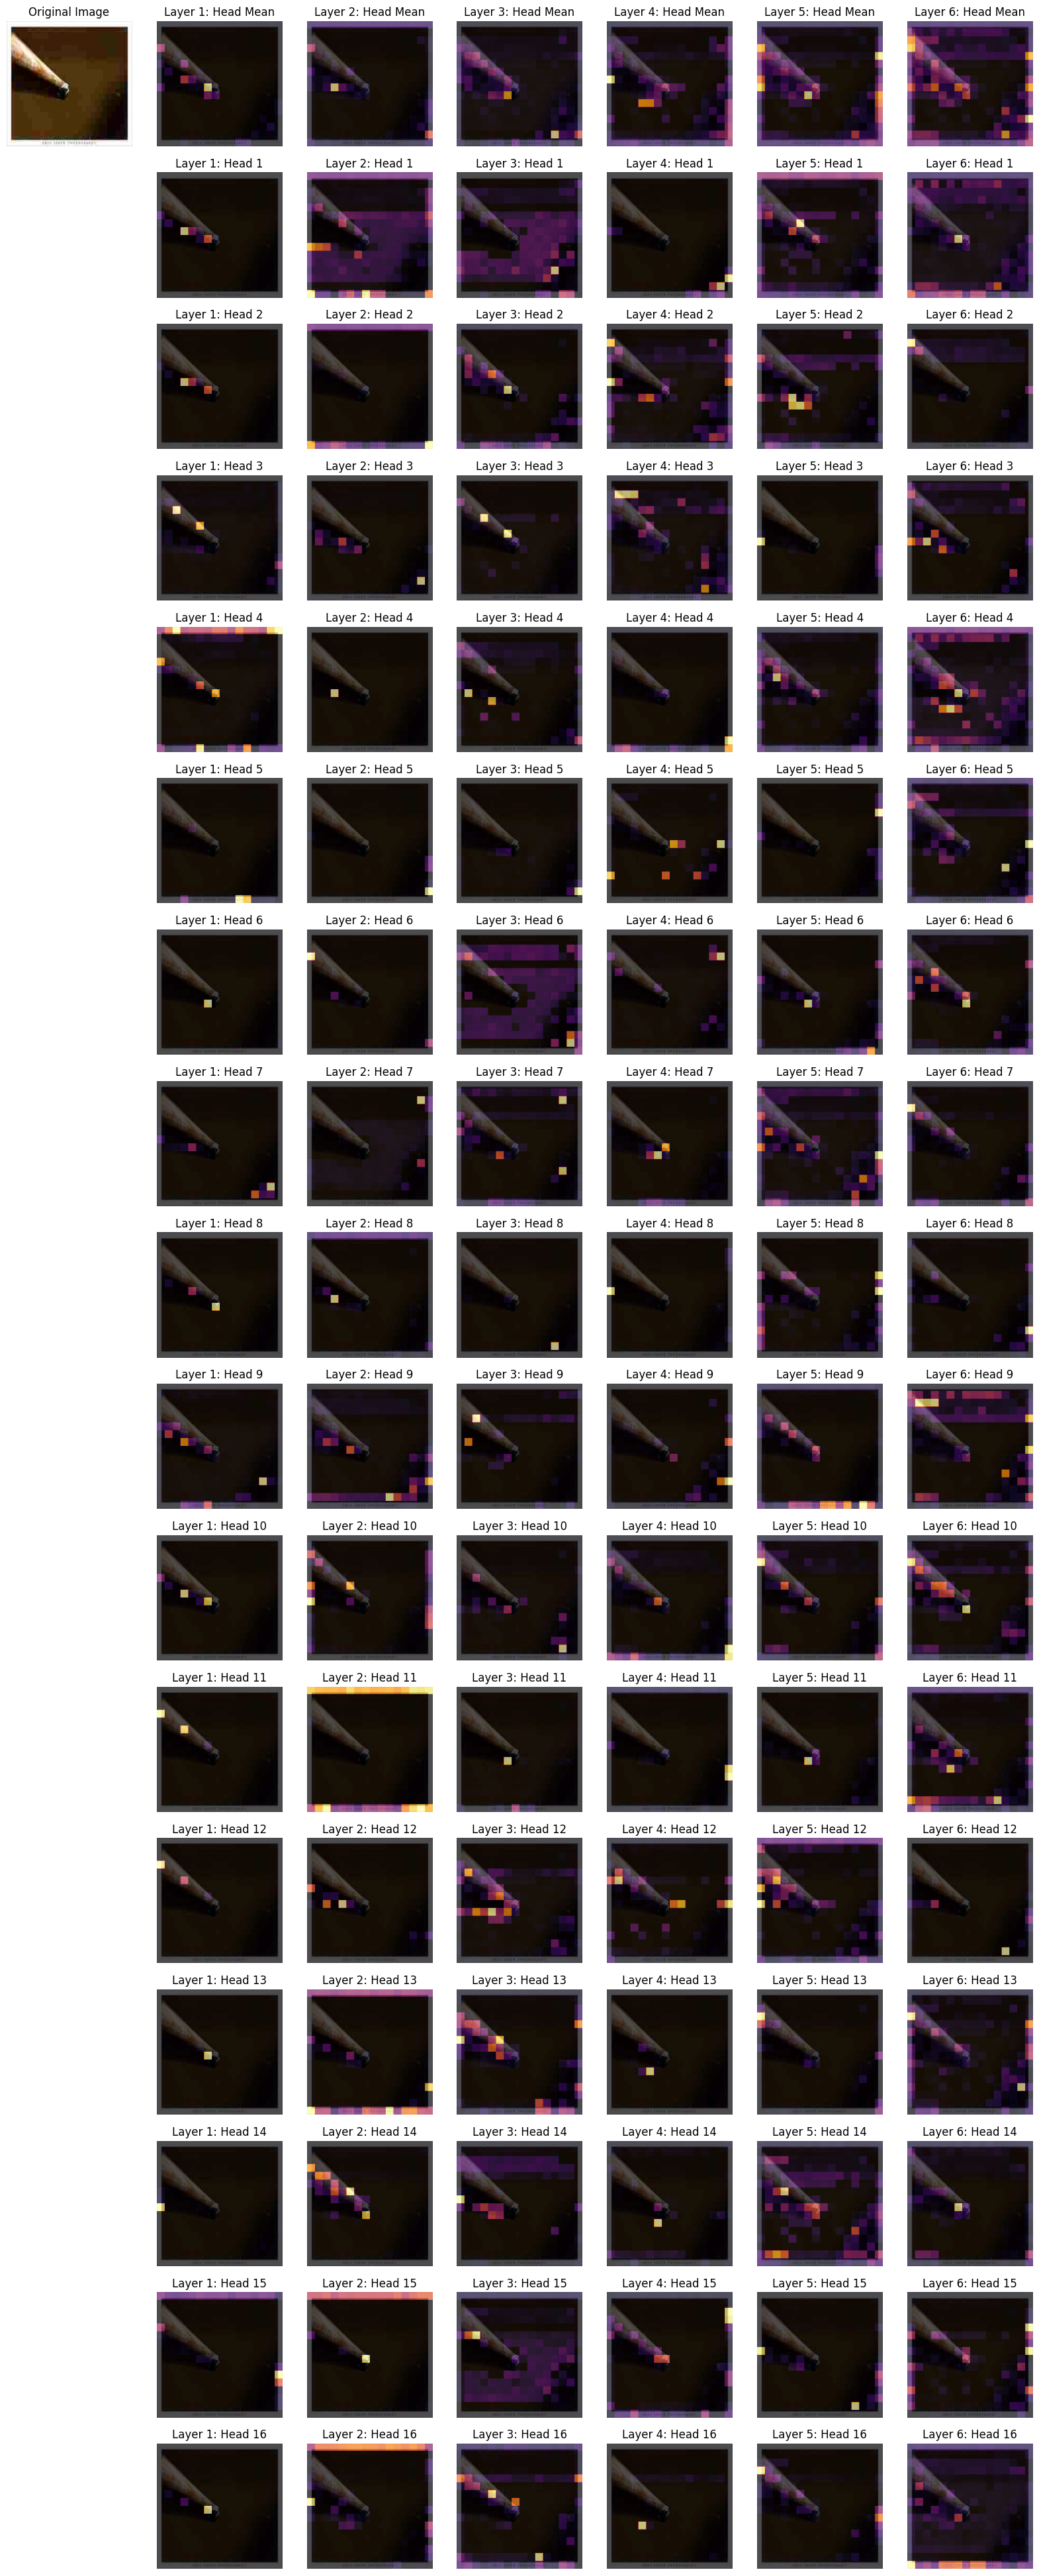

In [6]:
image_path = 'assets/work_imgs/1776ILSVRC2013_train_00025515.JPEG_I2_Q13.jpeg'

image = Image.open(image_path)
visualize_predict_all_layers(model, image, image_size, patch_size, 'cpu')

#### Plot Attention of single layer and all heads

In [ ]:
weight_file = 'results/AIOs/AIO0.pth'
model.load_state_dict(torch.load(weight_file))
model.eval()

Attention Shape: (6, 16, 256, 256)
Heads: 16


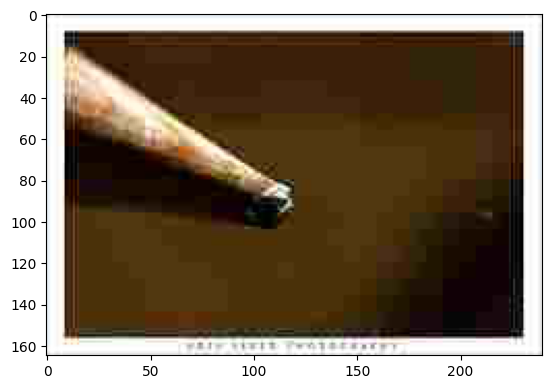

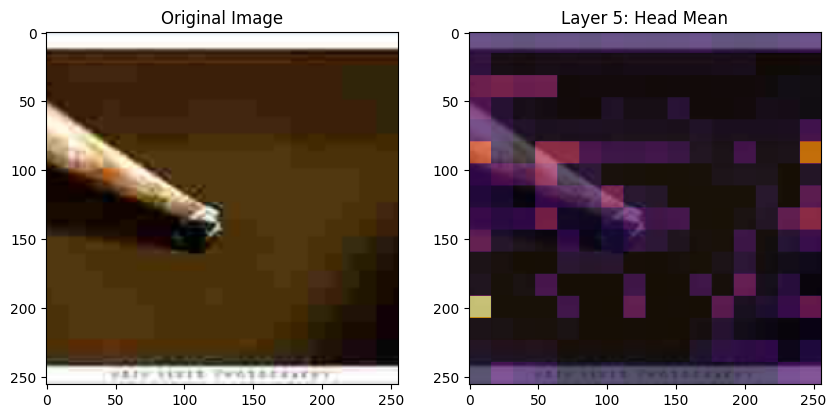

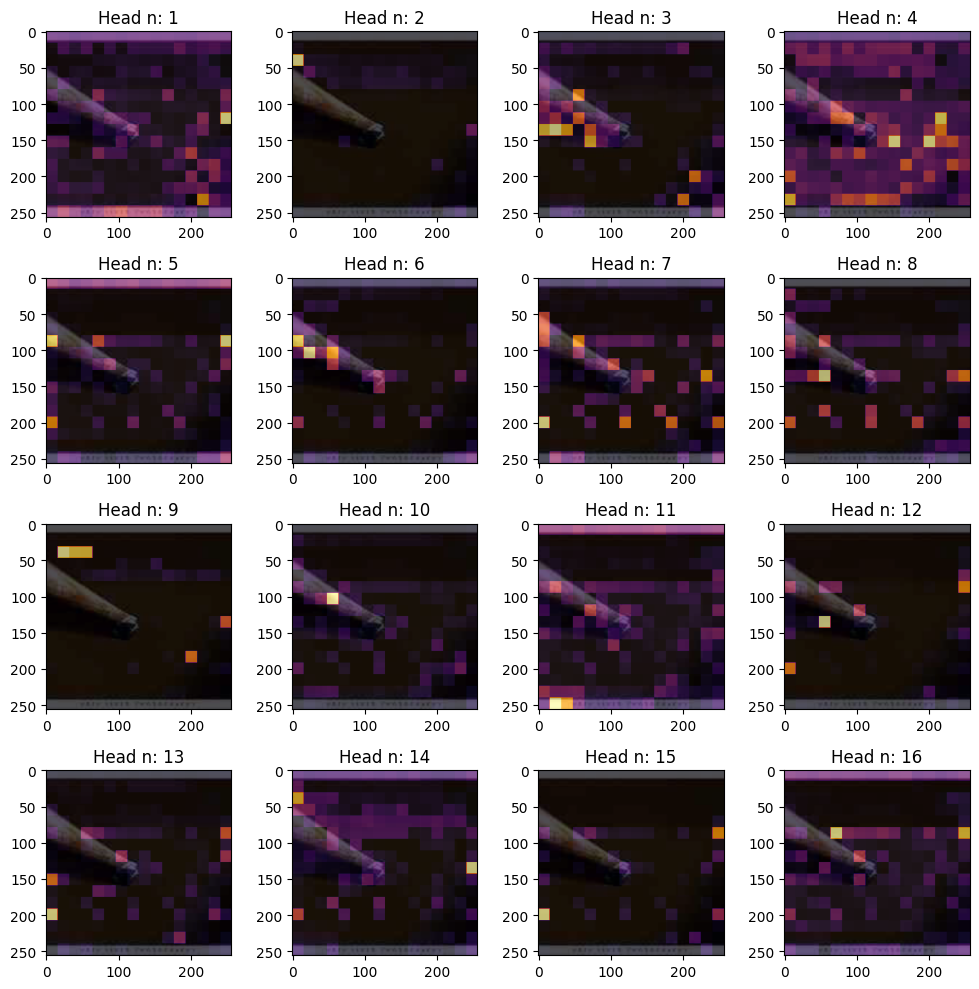

In [17]:
image_path = 'assets/work_imgs/1776ILSVRC2013_train_00025515.JPEG_I2_Q13.jpeg'
image = Image.open(image_path)
layer_idx = 5
visualize_predict_single_layer(model, image, image_size, patch_size, layer_idx, 'cpu')